In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d lukex9442/indian-bovine-breeds

Dataset URL: https://www.kaggle.com/datasets/lukex9442/indian-bovine-breeds
License(s): CC0-1.0
 99% 2.82G/2.84G [00:35<00:00, 72.4MB/s]
100% 2.84G/2.84G [00:35<00:00, 84.9MB/s]


In [ ]:
import zipfile
zipref = zipfile.ZipFile('/content/indian-bovine-breeds.zip','r')
zipref.extractall('/content')
zipref.close()

In [ ]:
import os
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import itertools
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# ================== CONSTANTS =================
IMAGE_SIZE = (299, 299)
BATCH_SIZE = 16   # larger images → smaller batch
DATA_DIR = '/content/Indian_bovine_breeds/Indian_bovine_breeds'
SEED = 123

In [ ]:
# ================== LOAD DATA ==================
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

CLASS_NAMES = np.array(train_ds.class_names)
NUM_CLASSES = len(CLASS_NAMES)
print("Classes:", NUM_CLASSES)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(2000).prefetch(AUTOTUNE)
val_ds   = val_ds.cache().prefetch(AUTOTUNE)

Found 5947 files belonging to 41 classes.
Using 4758 files for training.
Found 5947 files belonging to 41 classes.
Using 1189 files for validation.
Classes: 41


In [ ]:
# ================== AUGMENTATION ==================
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.15),
    tf.keras.layers.RandomZoom(0.15),
    tf.keras.layers.RandomContrast(0.1),
])


In [ ]:
# ================== MODEL ==================
base_model = tf.keras.applications.EfficientNetV2S(
    include_top=False,
    weights="imagenet",
    input_shape=IMAGE_SIZE + (3,)
)

base_model.trainable = False

inputs = tf.keras.Input(shape=IMAGE_SIZE + (3,))
x = data_augmentation(inputs)
x = tf.keras.applications.efficientnet_v2.preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(512, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = tf.keras.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

82420632/82420632 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-s (Functional)   │ (None, 10, 10, 1280)   │    20,331,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 41)             │        21,033 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,013,385 (80.16 MB)

 Trainable params: 679,465 (2.59 MB)

 Non-trainable params: 20,333,920 (77.57 MB)

In [ ]:
# ================== FIRST TRAIN ==================
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("Best_Cattle_Breed.keras", save_best_only=True),
    tf.keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True)
]

model.fit(train_ds, validation_data=val_ds, epochs=20, callbacks=callbacks)
model.summary()

Epoch 1/20
298/298 ━━━━━━━━━━━━━━━━━━━━ 150s 227ms/step - accuracy: 0.0820 - loss: 4.2280 - val_accuracy: 0.3103 - val_loss: 2.7009
Epoch 2/20
298/298 ━━━━━━━━━━━━━━━━━━━━ 56s 189ms/step - accuracy: 0.2139 - loss: 3.0577 - val_accuracy: 0.3877 - val_loss: 2.2135
Epoch 3/20
298/298 ━━━━━━━━━━━━━━━━━━━━ 56s 188ms/step - accuracy: 0.3074 - loss: 2.5998 - val_accuracy: 0.4458 - val_loss: 2.0018
Epoch 4/20
298/298 ━━━━━━━━━━━━━━━━━━━━ 55s 186ms/step - accuracy: 0.3298 - loss: 2.4320 - val_accuracy: 0.4668 - val_loss: 1.8853
Epoch 5/20
298/298 ━━━━━━━━━━━━━━━━━━━━ 54s 182ms/step - accuracy: 0.3886 - loss: 2.2561 - val_accuracy: 0.4886 - val_loss: 1.8102
Epoch 6/20
298/298 ━━━━━━━━━━━━━━━━━━━━ 82s 182ms/step - accuracy: 0.3953 - loss: 2.1180 - val_accuracy: 0.4870 - val_loss: 1.7770
Epoch 7/20
298/298 ━━━━━━━━━━━━━━━━━━━━ 55s 185ms/step - accuracy: 0.4275 - loss: 2.0159 - val_accuracy: 0.5156 - val_loss: 1.7226
Epoch 8/20
298/298 ━━━━━━━━━━━━━━━━━━━━ 54s 182ms/step - accuracy: 0.4427 - loss: 

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-s (Functional)   │ (None, 10, 10, 1280)   │    20,331,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 41)             │        21,033 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,372,317 (85.34 MB)

 Trainable params: 679,465 (2.59 MB)

 Non-trainable params: 20,333,920 (77.57 MB)

 Optimizer params: 1,358,932 (5.18 MB)

In [ ]:
# ================== FINE TUNING ==================
print("🔓 Fine tuning...")

base_model.trainable = True

fine_tune_at = int(len(base_model.layers) * 0.6)
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.fit(train_ds, validation_data=val_ds, epochs=40, callbacks=callbacks)
model.summary()

🔓 Fine tuning...
Epoch 1/40
298/298 ━━━━━━━━━━━━━━━━━━━━ 143s 317ms/step - accuracy: 0.4697 - loss: 1.9257 - val_accuracy: 0.5231 - val_loss: 1.7224
Epoch 2/40
298/298 ━━━━━━━━━━━━━━━━━━━━ 88s 294ms/step - accuracy: 0.5019 - loss: 1.7439 - val_accuracy: 0.5484 - val_loss: 1.6430
Epoch 3/40
298/298 ━━━━━━━━━━━━━━━━━━━━ 88s 294ms/step - accuracy: 0.5358 - loss: 1.5689 - val_accuracy: 0.5593 - val_loss: 1.5969
Epoch 4/40
298/298 ━━━━━━━━━━━━━━━━━━━━ 87s 292ms/step - accuracy: 0.5640 - loss: 1.4740 - val_accuracy: 0.5744 - val_loss: 1.5509
Epoch 5/40
298/298 ━━━━━━━━━━━━━━━━━━━━ 142s 292ms/step - accuracy: 0.5881 - loss: 1.3994 - val_accuracy: 0.5694 - val_loss: 1.5102
Epoch 6/40
298/298 ━━━━━━━━━━━━━━━━━━━━ 90s 302ms/step - accuracy: 0.5870 - loss: 1.3741 - val_accuracy: 0.5677 - val_loss: 1.4928
Epoch 7/40
298/298 ━━━━━━━━━━━━━━━━━━━━ 94s 313ms/step - accuracy: 0.6033 - loss: 1.2967 - val_accuracy: 0.5854 - val_loss: 1.4813
Epoch 8/40
298/298 ━━━━━━━━━━━━━━━━━━━━ 92s 308ms/step - accurac

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-s (Functional)   │ (None, 10, 10, 1280)   │    20,331,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 41)             │        21,033 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,349,789 (192.07 MB)

 Trainable params: 14,668,201 (55.95 MB)

 Non-trainable params: 6,345,184 (24.20 MB)

 Optimizer params: 29,336,404 (111.91 MB)

                   precision    recall  f1-score   support

         Alambadi     0.7368    0.5600    0.6364        25
       Amritmahal     0.4444    0.3333    0.3810        12
         Ayrshire     0.6939    0.8500    0.7640        40
            Banni     0.5455    0.4800    0.5106        25
           Bargur     0.8235    0.8235    0.8235        17
        Bhadawari     0.3000    0.2143    0.2500        14
      Brown_Swiss     0.7308    0.8444    0.7835        45
            Dangi     0.8000    0.5714    0.6667         7
            Deoni     0.5000    0.7273    0.5926        11
              Gir     0.7407    0.8696    0.8000        69
         Guernsey     0.6429    0.6667    0.6545        27
         Hallikar     0.5593    0.8250    0.6667        40
          Hariana     0.4242    0.4516    0.4375        31
Holstein_Friesian     0.8313    0.9452    0.8846        73
       Jaffrabadi     0.7059    0.8571    0.7742        14
           Jersey     0.7500    0.6000    0.6667       

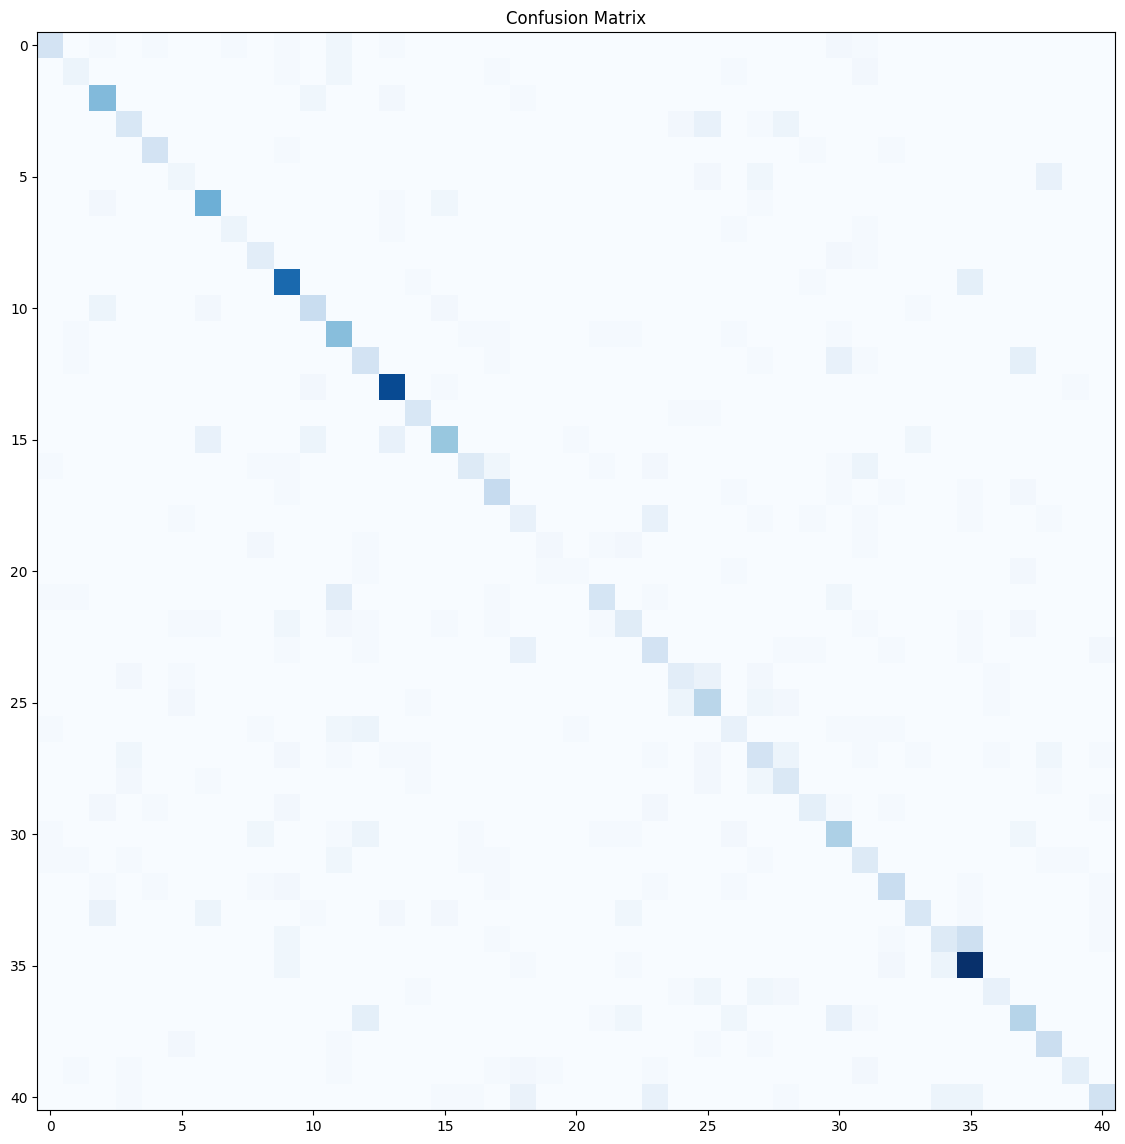

In [ ]:
# ================== EVALUATION ==================
y_true, y_pred = [], []

for images, labels in val_ds:
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

print(classification_report(y_true, y_pred, target_names=CLASS_NAMES, digits=4))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(14,14))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

acc = np.mean(np.array(y_true) == np.array(y_pred))

In [ ]:
# --- Classification Report ---
report = classification_report(
    y_true,
    y_pred,
    target_names=CLASS_NAMES,
    digits=4
)
print("\n📊 Classification Report:")
print(report)


📊 Classification Report:
                   precision    recall  f1-score   support

         Alambadi     0.7368    0.5600    0.6364        25
       Amritmahal     0.4444    0.3333    0.3810        12
         Ayrshire     0.6939    0.8500    0.7640        40
            Banni     0.5455    0.4800    0.5106        25
           Bargur     0.8235    0.8235    0.8235        17
        Bhadawari     0.3000    0.2143    0.2500        14
      Brown_Swiss     0.7308    0.8444    0.7835        45
            Dangi     0.8000    0.5714    0.6667         7
            Deoni     0.5000    0.7273    0.5926        11
              Gir     0.7407    0.8696    0.8000        69
         Guernsey     0.6429    0.6667    0.6545        27
         Hallikar     0.5593    0.8250    0.6667        40
          Hariana     0.4242    0.4516    0.4375        31
Holstein_Friesian     0.8313    0.9452    0.8846        73
       Jaffrabadi     0.7059    0.8571    0.7742        14
           Jersey     0.7500 

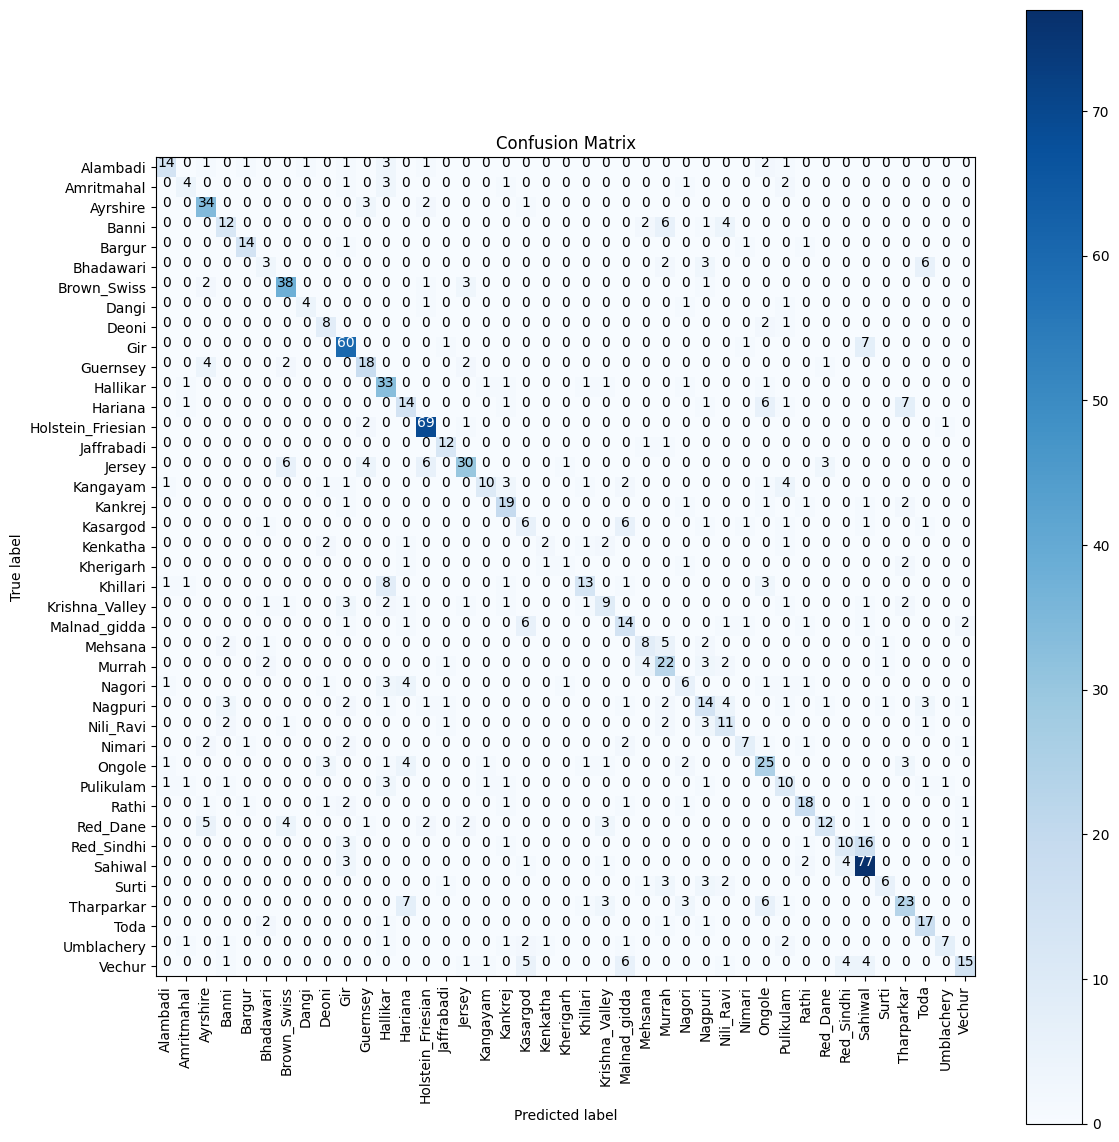

In [ ]:
# --- Confusion Matrix ---
cm = confusion_matrix(y_true, y_pred)

def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(12, 12))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(cm, CLASS_NAMES)

acc = np.mean(y_true == y_pred)


In [ ]:
!pip install gradio


In [ ]:
import gradio as gr
import numpy as np
import tensorflow as tf
import cv2
import os

MODEL_PATH = "/content/Best_Cattle_Breed.keras"
DATA_DIR = "/content/Indian_bovine_breeds/Indian_bovine_breeds"
IMAGE_SIZE = (299, 299)

model = tf.keras.models.load_model(MODEL_PATH)

CLASS_NAMES = sorted([
    d for d in os.listdir(DATA_DIR)
    if os.path.isdir(os.path.join(DATA_DIR, d))
])

def predict(image):
    image = cv2.resize(image, IMAGE_SIZE)
    image = tf.keras.applications.efficientnet_v2.preprocess_input(image.astype(np.float32))
    image = np.expand_dims(image, axis=0)

    preds = model.predict(image, verbose=0)
    class_id = np.argmax(preds[0])
    confidence = float(preds[0][class_id]) * 100

    return {CLASS_NAMES[class_id]: confidence}

demo = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="numpy"),
    outputs=gr.Label(num_top_classes=5),
    title="Cattle Breed Classifier",
    description="Upload an image of cattle to predict its breed"
)

demo.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://15a1885b17f0f3ee15.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
